In [1]:
import numpy as np
from sympy import *
import math
from collections import OrderedDict
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from sympy.plotting.plot import Plot, ContourSeries
import itertools
import seaborn as sns
%matplotlib inline

### Defining Functions

In [2]:
def get_global_k_matrix(elements_ls, global_to_local_ls, ndims, tz, gauss_points_xi, youngs_modulus, gauss_points_eta, poissons_ratio, plane, ty, quadratic_2d):
    '''
    This function returns the global K matrix of an element composed of other elements.
    
    For each element that composes the bigger element, this function obtaind the k matrix of the element and 
    maps it to its corresponding location in the global K matrix.
    
    parameter "elements_ls" refers to the list of elements that make up the greater element.
    
        Example: 
        
            elements_ls = [
                               element_1_2D_quadratic,
                               element_2_2D_quadratic,
                               element_3_2D_quadratic,
                               element_4_2D_quadratic,
                               element_5_2D_quadratic
                          ]
    
    and "global_to_local_ls" refers to the list of dictionaries that map nodes in one element to the global matrix.
    
        Example: 
    
            element_1_global_to_local_nodes = {1:7, 2:6, 3:5, 6:8, 7:4, 9:1, 10:2, 11:3}
            element_2_global_to_local_nodes = {3:7, 4:6, 5:5, 7:8, 8:4, 11:1, 12:2, 13:3}
            element_3_global_to_local_nodes = {9:7, 10:6, 11:5, 14:8, 15:4, 16:1, 17:2, 18:3}
            element_4_global_to_local_nodes = {11:7, 20:6, 24:5, 15:8, 23:4, 18:1, 19:2, 22:3}
            element_5_global_to_local_nodes = {11:7, 12:6, 13:5, 20:8, 21:4, 24:1, 25:2, 26:3}

            global_to_local_ls = [
                                    element_1_global_to_local_nodes,
                                    element_2_global_to_local_nodes,
                                    element_3_global_to_local_nodes,
                                    element_4_global_to_local_nodes,
                                    element_5_global_to_local_nodes
                                 ]
    
    Note: the ty parameter will always be None because this function only works for 2-D elements.
    '''
    
    # Get total number of nodes
    global_node_number_ls = []
    for node_dict in global_to_local_ls:
        global_node_number = list(node_dict.keys())
        global_node_number_ls.append(global_node_number)

    global_node_number_ls = [node for nodes_ls in global_node_number_ls for node in nodes_ls]
    global_nodes = set(global_node_number_ls)

    num_nodes_total = len(global_nodes)
    
    # Initialize globak K matrix with zeros
    global_k_matrix = zeros(2*num_nodes_total, 2*num_nodes_total)
    
    # Map lacal k matrix values to global K matrix
    for element, global_to_local_element_dict in zip(elements_ls, global_to_local_ls):

        local_k_matrix = element.get_local_k_matrix(ndims, tz, gauss_points_xi, youngs_modulus, gauss_points_eta, poissons_ratio, plane, ty, quadratic_2d)
        
        for global_node_number, local_node_number in global_to_local_element_dict.items():
            row_x_global = (global_node_number*2) - 2
            row_y_global = (global_node_number*2) - 1
            row_x_local  = (local_node_number*2)  - 2
            row_y_local  = (local_node_number*2)  - 1

            for global_node_number, local_node_number in global_to_local_element_dict.items():
                column_x_global = (global_node_number*2) - 2
                column_y_global = (global_node_number*2) - 1
                column_x_local  = (local_node_number*2)  - 2
                column_y_local  = (local_node_number*2)  - 1  

                global_k_matrix[row_x_global, column_x_global] += local_k_matrix[row_x_local, column_x_local]
                global_k_matrix[row_x_global, column_y_global] += local_k_matrix[row_x_local, column_y_local]
                global_k_matrix[row_y_global, column_x_global] += local_k_matrix[row_y_local, column_x_local]
                global_k_matrix[row_y_global, column_y_global] += local_k_matrix[row_y_local, column_y_local]
            
    return global_k_matrix

In [3]:
def get_global_force_vector(num_nodes_global, global_to_local_ls, force_vector_ls):
    '''
    This function returns the global force vector.
    
    the arguments "global_to_local_ls" and "force_vector_ls" refer only to the elements where a 
    surface force is acting on. 
    
    While "num_nodes_global" refers to the total number of nodes in the assembly.
    
    '''
    
    global_force_vector = zeros(2*num_nodes_global, 1)
    
    for global_to_local_element_dict, force_vector in zip(global_to_local_ls, force_vector_ls):
        for global_node_number, local_node_number in global_to_local_element_dict.items():

            row_x_global = (global_node_number*2) - 2
            row_y_global = (global_node_number*2) - 1
            row_x_local  = (local_node_number*2)  - 2
            row_y_local  = (local_node_number*2)  - 1

            global_force_vector[row_x_global, 0] += force_vector[row_x_local, 0]
            global_force_vector[row_y_global, 0] += force_vector[row_y_local, 0]
            
    return global_force_vector

In [4]:
def global_replace_q_with_Q(num_nodes_global, global_to_local_ls, elements_ls, Q):
    '''
    
    '''

    for global_to_local_element_dict, element in zip(global_to_local_ls, elements_ls):
        
        node_objects_ls = list(element.nodes_dict.values())
        
        for global_node_number, local_node_number in global_to_local_element_dict.items():
            
            node = node_objects_ls[local_node_number-1]

            row_x_global = (global_node_number*2) - 2
            row_y_global = (global_node_number*2) - 1
            row_x_local  = (local_node_number*2)  - 2
            row_y_local  = (local_node_number*2)  - 1
 
            node.x_displacement = Q[row_x_global] 
            node.y_displacement = Q[row_y_global]

### Defining Classes

In [5]:
class Node:
    def __init__(self, x, x_displacement, y=0, y_displacement=0, z=0, z_displacement=0, xi=0, eta=0, zeta=0):
        self.x = x
        self.y = y
        self.z = z
        self.x_displacement = x_displacement
        self.y_displacement = y_displacement 
        self.z_displacement = z_displacement
        self.xi = xi
        self.eta = eta        
        self.zeta = zeta
        
    def __str__(self):
        return f'x-space: <{self.x}, {self.y}, {self.z}>   xi-space: <{self.xi}, {self.eta}, {self.zeta}>   displacement: <{self.x_displacement}, {self.y_displacement}, {self.z_displacement}>'

In [6]:
class Element:    
    def __init__(self, nodes_dict):
        self.nodes_dict = nodes_dict
        
    def __str__(self):    
        nodes = []
        for key, value in self.nodes_dict.items():
            nodes.append(f'{key} --> {value}')

        return '\n'.join(nodes)
    
    @staticmethod
    def validate_parameter(parameter, acceptable_parameters_ls):
        if parameter not in acceptable_parameters_ls:
            raise TypeError(f'This method takes no parameter {parameter} try one of these: {acceptable_parameters_ls}')
    
    @staticmethod
    def get_d_mat(youngs_modulus, poissons_ratio=None, plane=None):
        '''
        This function returns the D matrix. 
        '''

        v = symbols('nu')
        E = symbols('E')

        if plane == 'stress':
            mat = Matrix(3,3, [1, v, 0, v, 1, 0, 0, 0, (1-v)/2])
            const = E/(1-v**2)
            plane_stress_mat = const*mat
            stiff_mat = plane_stress_mat.subs([(E, youngs_modulus), (v, poissons_ratio)])
        elif plane == 'strain':
            mat = Matrix(3,3, [1-v, v, 0, v, 1-v, 0, 0, 0, (1-2*v)/2])
            const = E/((1+v)*(1-2*v))
            plane_strain_mat = const*mat
            stiff_mat = plane_strain_mat.subs([(E, youngs_modulus), (v, poissons_ratio)])
        elif plane == None:
            stiff_mat = youngs_modulus

        return stiff_mat
    
    @staticmethod
    def get_gauss_points_and_weights():
        points_arr = np.array([[                                0,                                 0,                             0,                                0,                                0],
                               [                   -(1 / sqrt(3)),                     (1 / sqrt(3)),                             0,                                0,                                0],
                               [                       -sqrt(3/5),                                 0,                     sqrt(3/5),                                0,                                0],
                               [   -sqrt(3/7 + (2/7) * sqrt(6/5)),    -sqrt(3/7 - (2/7) * sqrt(6/5)), sqrt(3/7 - (2/7) * sqrt(6/5)),    sqrt(3/7 + (2/7) * sqrt(6/5)),                                0],
                               [-(1/3) * sqrt(5 + 2 * sqrt(10/7)), -(1/3) * sqrt(5 - 2 * sqrt(10/7)),                             0, (1/3) * sqrt(5 - 2 * sqrt(10/7)), (1/3) * sqrt(5 + 2 * sqrt(10/7))]])

        points_mat = Matrix(points_arr)

        weights_arr =  np.array([[                          2,                           0,                      0,                           0,                           0],
                                 [                          1,                           1,                      0,                           0,                           0],
                                 [                        5/9,                         8/9,                    5/9,                           0,                           0],
                                 [     ((18 - sqrt(30)) / 36),      ((18 + sqrt(30)) / 36), ((18 + sqrt(30)) / 36),      ((18 - sqrt(30)) / 36),                           0],
                                 [((322 - 13*sqrt(70)) / 900), ((322 + 13*sqrt(70)) / 900),                      0, ((322 + 13*sqrt(70)) / 900), ((322 - 13*sqrt(70)) / 900)]])

        weights_mat = Matrix(weights_arr)

        return points_mat, weights_mat
    
    @staticmethod
    def add_C_to_k_matrix(ndims, global_k_matrix, global_nodes_BCs_applied_to, direction_BCs_applied=None):
        '''
        This function adds C to the global K matrix

        This function should only be used when there are displacement boundary conditions applied to the element.

        The argument "global_nodes_BCs_applied_to" should be passed in as a list with the numbers of the nodes 
        where a displacement boundary condition is being applied to. 

            Example:

                global_nodes_BCs_applied_to = [1, 4]

        The argument "direction_BCs_applied" should be passed in as a list of a list of strings that correspond to
        the direction of the displacement boundary condition being applied to the node number of corresponding indexing
        in the "global_nodes_BCs_applied_to" argument. 

            Example:

                direction_BCs_applied       = ['xy', 'x']
                                                ^     ^
                                                |     |
                global_nodes_BCs_applied_to = [ 1  ,  4 ]

        Note: There is no need to pass in "direction_BCs_applied" if the element is 1-D.
        '''
        
        # Get C
        C = max(abs(global_k_matrix)) * (10**4)

        if ndims == 1:

            for node in global_nodes_BCs_applied_to:

                row_x_global = node - 1
                col_x_global = row_x_global

                global_k_matrix[row_x_global, col_x_global] += C

        if ndims == 2: 

            for node, direction in zip(global_nodes_BCs_applied_to, direction_BCs_applied):

                if direction == 'xy':
                    row_x_global = (node*2) - 2
                    row_y_global = (node*2) - 1

                    col_x_global = row_x_global
                    col_y_global = row_y_global

                    global_k_matrix[row_x_global, col_x_global] += C
                    global_k_matrix[row_y_global, col_y_global] += C

                elif direction == 'x':
                    row_x_global = (node*2) - 2
                    col_x_global = row_x_global

                    global_k_matrix[row_x_global, col_x_global] += C

                elif direction == 'y':
                    row_y_global = (node*2) - 1
                    col_y_global = row_y_global

                    global_k_matrix[row_y_global, col_y_global] += C

        return global_k_matrix
    
    @staticmethod
    def add_C_times_delta_to_force_vector(ndims, global_force_vector, C, deltas, global_nodes_BCs_applied_to, direction_BCs_applied=None):
        '''

        '''
        
        if ndims == 1:

            for node, delta in zip(global_nodes_BCs_applied_to, deltas):

                C_times_delta = C*delta

                row_x_global = node - 1

                global_force_vector[row_x_global, 0] += C_times_delta

        if ndims == 2: 

            for node, direction, delta in zip(global_nodes_BCs_applied_to, direction_BCs_applied, deltas):

                if direction == 'xy':

                    C_times_delta_x = C*delta[0]
                    C_times_delta_y = C*delta[1]

                    row_x_global = (node*2) - 2
                    row_y_global = (node*2) - 1

                    global_force_vector[row_x_global, 0] += C_times_delta_x
                    global_force_vector[row_y_global, 0] += C_times_delta_y

                elif direction == 'x':

                    C_times_delta = C*delta

                    row_x_global = (node*2) - 2

                    global_force_vector[row_x_global, 0] += C_times_delta

                elif direction == 'y':

                    C_times_delta = C*delta

                    row_y_global = (node*2) - 1

                    global_force_vector[row_y_global, 0] += C_times_delta

        return global_force_vector
        
    def get_nodes_info(self, info):
        '''
        This method takes either one of three arguments:
        
        info = "xyz" 
        or 
        info = "displacements"
        or
        info = "xietazeta"
        
        
        This method returns a numpy array with the given format:

                            x --> array([[ ],
                            y -->        [ ],
                            z -->        [ ]])
                                          ^
                                          |
                                         node
                                         
        The array returned could be either one of the nodes' attributes: xyz-coordinates or displacement. 
        Therefore, the method takes either one of two arguments: "xyz" or "displacements".

           Example 1:

               For an element with two nodes in 1-D (x-axis):
                               1          2
                               o----------o
                (x=0, y=0, z=0)            (x=10, y=0, z=0)

               Returns numpy array:
                                   x --> array([[0,   10],
                                   y -->        [0,    0],
                                   z -->        [0,    0]])
                                                 ^     ^
                                                 |     |
                                               node1  node2

           Example 2:

               For an element with three nodes in 1-D (x-axis):
                               1          2          3
                               o----------o----------o
                (x=0, y=0, z=0)   (x=5, y=0, z=0)    (x=10, y=0, z=0)

               Returns numpy array:
                                   x --> array([[0,    5,    10],
                                   y -->        [0,    0,     0],
                                   z -->        [0,    0,     0]])
                                                 ^     ^      ^
                                                 |     |      |
                                               node1  node2  node3

           Example 3:

               For an element with four nodes in 2-D (x-axis, y-axis):

                     (x=0, y=10, z=0)      (x=10, y=10, z=0)
                                4 o-------o 3
                                  |       |
                                  |       |
                               1  o-------o 2
                     (x=0, y=0, z=0)      (x=10, y=0, z=0)

               Returns numpy array:
                                   x --> array([[0,    10,    10,     0],
                                   y -->        [0,     0,    10,    10],
                                   z -->        [0,     0,     0,     0]])
                                                 ^      ^      ^      ^
                                                 |      |      |      |
                                               node1   node2  node3  node4 
                                               
        '''
        
        # Acceptable parameters list
        acceptable_parameters_ls = ['xyz', 'xietazeta', 'displacements']
        
        # Validate parameter passed to method
        Element.validate_parameter(info, acceptable_parameters_ls)
        
        # Specify list with nodes attributes names depending on argument passed
        if info == 'xyz':
            axes_info_ls = ['x', 'y', 'z']

        elif info == 'displacements':
            axes_info_ls = ['x_displacement', 'y_displacement', 'z_displacement']
            
        elif info == 'xietazeta':
            axes_info_ls = ['xi', 'eta', 'zeta']

        # Get nodes dictionary 
        nodes_dict = self.nodes_dict

        # Get node objects store inside nodes_dict
        node_objects = nodes_dict.values()

        # Get all objects' wanted attributes info inside of dictionary
        info_ls = [getattr(node_object, axes_info) 
                            for axes_info in axes_info_ls for node_object in node_objects]

        # Reshape the array
        # #rows = 3, one for each axis
        # #columns = #nodes
        info_arr = np.array(info_ls).reshape(len(axes_info_ls), len(node_objects))

        return info_arr
    
    def get_nonzero_axes(self, array):
        '''
        This method takes either one of three parameters:
        
        array = "xyz" 
        or 
        array = "displacements"
        or 
        array = "xietazeta"
        
        just like the .get_nodes_info() method.
        
        This method returns all non-zero axis in the nodes dictionary. 
        The axes valus are obtained through the .get_nodes_info() method, 
        then the values of each axis is checked to see if all values are zero.
        If they are, then the axis is discarded and the others are stored in a dictionary,
        where the keys are the respective axes names.

            Example:

                   For an element with two nodes in 1-D (x-axis):
                                   1          2
                                   o----------o
                    (x=0, y=0, z=0)            (x=10, y=0, z=0)

                   The .get_nodes_info() method provides this numpy array:

                                       x --> array([[0,   10],
                                       y -->        [0,    0],
                                       z -->        [0,    0]])
                                                     ^     ^
                                                     |     |
                                                   node1  node2

                   The rows representing the y and z axis only have values of zero.
                   These rows are discarded and the function returns a dictionary with only
                   the x-axis:

                                       {'x': array([ 0, 10])}

                   Note: the keys are strings with axis name and the values are numpy arrays with axis 
                         points.

        '''
        
        # Acceptable parameters list
        acceptable_parameters_ls = ['xyz', 'xietazeta', 'displacements']
        
        # Validate parameter passed to method
        Element.validate_parameter(array, acceptable_parameters_ls)
        
        # Get the array to be screened for non-zero axes
        array_scrn = self.get_nodes_info(info=array)
        
        # Specify axes
        axes_ls = ['x', 'y', 'z'] if array != 'xietazeta' else ['xi', 'eta', 'zeta']

        # Loop through axes coordinates array and place non-zero axes in dictionary
        nonzero_axes_dict = {axis:row for row, axis in zip(array_scrn, axes_ls) if np.count_nonzero(row) != 0}

        return nonzero_axes_dict
    
    def get_ndims(self):
        ndims = len(list((self.get_nonzero_axes(array='xyz')).keys()))
        return ndims
    
    def get_constants(self, array):
        '''
        This method takes one of two arguments:
        
        array = "xyz"
        or 
        array = "xietazeta"
        
        This method returns a dictionary axes constants. When formulating the shape function of a node,
        the value of the node at that location needs to be 1, while being 0 at all other node locations.
        Therefore, other nodes' axial positions should be subtracted from the axial variable to ensure 
        the node's value at that position is 0. 

            Example 1:

               For an element with four nodes in 2-D (x-axis, y-axis):

                    (x=0, y=10, z=0)      (x=10, y=10, z=0)
                            4 o-------o 3
                              |       |
                              |       |
                            1 o-------o 2
                    (x=0, y=0, z=0)      (x=10, y=0, z=0)

               The general shape function for node1 is:

                   N1(x, y) = (x - 10)(y - 10)C , where C = constant

               In this example, (x - 10) guarantees the shape function will always be zero when x "is at" another node.
               The same goes for (y - 10) when y "is at" another node. This method returns all the constants that, 
               when subtracting the axial variable (e.g., "x", "y", or "z") make the shape function zero.

               The function in this case returns:

                           {'x_constants': array([[10],   --> from (x - 10)
                                                  [ 0],
                                                  [ 0],
                                                  [10]]),
                            'y_constants': array([[10],   --> from (y - 10)
                                                  [10],
                                                  [ 0],
                                                  [ 0]])}

               Where the value for each key is an array with #rows = #nodes
                                                             #columns = #unique axial values where there are other nodes

            Example 2:

               For an element with three nodes in 1-D (x-axis):

                                   1          2          3
                                   o----------o----------o
                    (x=0, y=0, z=0)   (x=5, y=0, z=0)    (x=10, y=0, z=0)


               The general shape function for node1 is:

                   N2(x, y) = (x - 0)(x - 10)C , where C = constant


               The function in this case returns:

                          {'x_constants': array([[ 5, 10],
                                                 [ 0, 10],  --> from (x - 0)(x - 10) 
                                                 [ 0,  5]])}

        '''
        
        # Acceptable parameters list
        acceptable_parameters_ls = ['xyz', 'xietazeta']
        
        # Validate parameter passed to method
        Element.validate_parameter(array, acceptable_parameters_ls)
        
        # Get non-zero axis
        nonzero_axes = self.get_nonzero_axes(array=array)

        # Loop through axis values in dictionary obtained with .get_nonzero_axes() method and
        # stores other nodes' unique values in array
        constants_dict = {}
        for axis, axis_values in nonzero_axes.items():
            other_nodes_values_ls = []
            for value in axis_values:
                other_nodes_values = axis_values[axis_values != value] 
                other_nodes_values = list(OrderedDict.fromkeys(other_nodes_values)) # only unique values considered
                other_nodes_values_ls.append(np.array(other_nodes_values))
            constants_dict[axis] = np.array(other_nodes_values_ls)  # _constants
        return constants_dict
    
    def get_products(self, array):
        '''
        This method takes one of two arguments:
        
        array = "xyz"
        or
        array = "xietazeta"
        
        This function returns the product of all axial variables minus the axial constants.
        The inverse of the product will be the constant "C" of the node's shape function.

        Example:

            For an element with four nodes in 2-D (x-axis, y-axis):

                (x=0, y=10, z=0)      (x=10, y=10, z=0)
                        4 o-------o 3
                          |       |
                          |       |
                        1 o-------o 2
                (x=0, y=0, z=0)      (x=10, y=0, z=0)

            The general shape function for node1 is:

            N1(x, y) = (x - 10)(y - 10)C

            To find the value of C, the function has to be analyzed at the node's position and set equal to 1: 
            N1(x=0, y=0) = (0 - 10)(0 - 10)C = 1
                           \--------------/
                                   ^
                                   |
                                   |
            the product of these two parenthesis is the product returned by the function.
            The function returns one product for each node.

            In this example, the function returns a numpy array:

                            array([[ 100, -100,  100, -100]])
                                      ^
                                      |
                               product node1

        '''
        
        # Acceptable parameters list
        acceptable_parameters_ls = ['xyz', 'xietazeta']
        
        # Validate parameter passed to method
        Element.validate_parameter(array, acceptable_parameters_ls)

        # Get non-zero axes
        nonzero_axes = self.get_nonzero_axes(array=array)

        # Get constants 
        constants = self.get_constants(array=array)

        # Subtract axis value from constants and store it a list
        product_ls = [ [nonzero_axes[key_nonzero_axes] - constants[key_constants].T]
                       for key_nonzero_axes, key_constants in zip(nonzero_axes, constants)]

        # Multiply parenthesis
        products = np.prod(product_ls, axis=1)
        products = np.prod(products, axis=0)
        products = np.prod(products, axis=0)
        
        return products
    
    def get_shape_functions(self, array):
        '''
        This method takes one of two arguments:
        
        array = "xyz"
        or
        array = "xietazeta"
        
        This function returns the shape functions of all nodes in the nodes dictionary.

        Example:

            For an element with four nodes in 2-D (x-axis, y-axis):

                (x=0, y=10, z=0)      (x=10, y=10, z=0)
                            4 o-------o 3
                              |       |
                              |       |
                            1 o-------o 2
                (x=0, y=0, z=0)      (x=10, y=0, z=0)

            The general shape function for node1 is:

            N1(x, y) = (x - 10)(y - 10)C

            The equations inside the parenthesis can be made by subtrating a symbolic variable 
            from the array obtained with .get_constants(). The parenthesis are then divided by 
            the products obtained with .get_products() since C = 1/product.

            In this example the method returns a numpy array that contains symbolic expressions
            representing the shape functions:

                array([(x - 10)*(y - 10)/100, -x*(y - 10)/100, x*y/100, -y*(x - 10)/100], dtype=object)

        '''

        # Get constants
        constants_dict = self.get_constants(array)

        # Get products
        products = self.get_products(array)

        # Subtract symbolic variables from constants and store them in a list
        parenthesis_ls = [np.prod(symbols(axis) - constants, axis=1) for axis, constants in constants_dict.items()]

        # Divide parenthetic expression by the product to get shape functions
        shape_functions_arr = np.prod(parenthesis_ls, axis=0) / products

        return shape_functions_arr

#     def get_shape_functions(self, array):
#         N1 = ((xi-0)*(xi-1)*(eta-1)) / -4
#         N2 = ((xi+1)*(xi-1)*(eta-1)) / 2
#         N3 = ((xi+1)*(xi-0)*(eta-1)) / -4
#         N4 = ((xi+1)*(xi-0)*(eta+1)) / 4
#         N5 = ((xi+1)*(xi-1)*(eta+1)) / -2
#         N6 = ((xi-0)*(xi-1)*(eta+1)) / 4

#         shape_funcs_ls = np.array([N1, N2, N3, N4, N5, N6])
#         return shape_funcs_ls
    
    def get_2d_quadratic_natl_shape_functions(self):
        xi = symbols('xi')
        eta = symbols('eta')
        non_zero_axes = self.get_nonzero_axes(array='xietazeta') # 'xyz' --> 'xietazeta'
        non_zero_axes_ls = list(non_zero_axes.values())
        coord_vect = np.vstack(non_zero_axes_ls).T
        coord_vect

        shape_functions_ls = []
        for coord in coord_vect:
            if 0 not in coord:
                rid_lines = (xi + coord[0])*(eta + coord[1])
                y_intercept = coord[1]
                slope = -(np.prod(coord))
                rid_diagonal = -eta + (slope*xi) + y_intercept
                parenthesis = rid_lines*rid_diagonal
                product = parenthesis.subs([(xi, coord[0]), (eta, coord[1])])
                shape_function = parenthesis / product
                shape_functions_ls.append(shape_function)
            else:
                if coord[0] == 0:
                    rid_parallel_lines = (xi + 1)*(xi - 1)
                    rid_perpendicular_line = eta + coord[1]
                    parenthesis = rid_parallel_lines*rid_perpendicular_line
                    product = parenthesis.subs([(xi, coord[0]), (eta, coord[1])])
                    shape_function = parenthesis / product
                    shape_functions_ls.append(shape_function)
                else:
                    rid_parallel_lines = (eta + 1)*(eta - 1)
                    rid_perpendicular_line = xi + coord[0]
                    parenthesis = rid_parallel_lines*rid_perpendicular_line
                    product = parenthesis.subs([(xi, coord[0]), (eta, coord[1])])
                    shape_function = parenthesis / product
                    shape_functions_ls.append(shape_function)
        shape_functions_arr = np.array(shape_functions_ls)

        return shape_functions_arr
    
    def get_disp_functions(self, array):
        '''
        This method takes one of two arguments:
    
        array = "xyz"
        or
        array = "xietazeta"
        
        This function returns a dictionary of displacement functions for each non-zero axis.

            Example:

                For an element with four nodes in 2-D (x-axis, y-axis):

                    (x=0, y=10, z=0)      (x=10, y=10, z=0)
                                4 o-------o 3
                                  |       |
                                  |       |
                                1 o-------o 2
                    (x=0, y=0, z=0)      (x=10, y=0, z=0)

                The function returns:

                {'x': array([0, -0.001*x*(y - 10), 0.001*x*y, 0.001*y*(x - 10)], dtype=object),
                 'y': array([0, 0.001*x*(y - 10), 0.001*x*y, -0.001*y*(x - 10)], dtype=object)}

        '''

        # Get shape functions
        shape_functions = self.get_shape_functions(array=array)

        # Get displacemnts
        disp_vect_dict = self.get_nonzero_axes(array='displacements') 

        # Multiply shape functions by displacements, store in dictionary
        disp_funcs_dict = {axis : np.sum(shape_functions*disp_vect_dict[axis]) for axis in disp_vect_dict}

        return disp_funcs_dict
    
    def get_2d_quadratic_natl_disp_functions(self):
        # Get shape functions
        shape_functions = self.get_2d_quadratic_natl_shape_functions()

        # Get displacemnts
        disp_vect_dict = self.get_nonzero_axes(array='displacements') 

        # Multiply shape functions by displacements, store in dictionary
        disp_funcs_dict = {axis : np.sum(shape_functions*disp_vect_dict[axis]) for axis in disp_vect_dict}

        return disp_funcs_dict
    
    def get_location_functions(self):
        '''
        This method returns the location functions (converted from xi-space to x-space).
        It only applies to nodes that have xi-space coordinates.
        '''

        # Get xi-space shape functions
        shape_functions = self.get_shape_functions(array='xietazeta')

        # Get locations
        location_vect_dict = self.get_nonzero_axes(array='xyz') 

        # Multiply shape functions by locations, store in dictionary
        location_funcs_dict = {axis : np.sum(shape_functions*location_vect_dict[axis]) for axis in location_vect_dict}

        return location_funcs_dict
    
    def get_2d_quadratic_natl_location_functions(self):
        # Get xi-space shape functions
        shape_functions = self.get_2d_quadratic_natl_shape_functions()

        # Get locations
        location_vect_dict = self.get_nonzero_axes(array='xyz') 

        # Multiply shape functions by locations, store in dictionary
        location_funcs_dict = {axis : np.sum(shape_functions*location_vect_dict[axis]) for axis in location_vect_dict}

        return location_funcs_dict
    
    def get_jacobian(self, quadratic_2d=False):
        '''
        This method returns the Jacobian of an element as an array.
        
        Example:
        
                >>> element_2D_linear.get_jacobian()
                
                array([[eta + 7, -eta/4 - 3/4],
                       [xi + 1/2, 19/4 - xi/4]], dtype=object)
        '''
        
        # Get location functions
        if quadratic_2d:
            location_functions = self.get_2d_quadratic_natl_location_functions()
        else:
            location_functions = self.get_location_functions()

        # Initialize list for derivatives of location functions (which make a Jacobian matrix)
        jacobian_ls = []

        # Loop through every location function 
        # Take the derivative of each function with respect to each axis (xi, eta, etc.)
        # Append derivatives to jacobian_ls
        for key in location_functions:
            location_function = location_functions[key]
            syms = list(location_function.free_symbols)
            syms = [symbols('xi'), symbols('eta')] if len(syms) == 2 else [symbols('xi')]
            for sym in syms:
                jacobian_ls.append(diff(location_function, sym))

        # Turn jacobian_ls into numpy array
        jacobian_arr = np.array(jacobian_ls)

        # Get length of jacobian_arr
        num_functions = len(jacobian_arr)

        # If the lenght of the list is greater than 1, then array needs to be reshaped 
        if num_functions > 1:
            dimmension = int(num_functions / 2)
            jacobian_arr = jacobian_arr.reshape(dimmension, dimmension).T

        # Return Jacobian matrix (array)
        return Matrix(jacobian_arr)
    
    def get_shape_functions_derivative(self, array='xietazeta', quadratic_2d=False):
        '''
        This method returs the first derivatives of the shape functions with respect to each axis.
        '''
        if quadratic_2d:
            shape_functions = self.get_2d_quadratic_natl_shape_functions()
        else:
            shape_functions = self.get_shape_functions(array)
            
        shape_functions_derivative_ls = []
        for shape_function in shape_functions:
            syms = list(shape_function.free_symbols)
            syms = [symbols('xi'), symbols('eta')] if len(syms) == 2 else [symbols('xi')]
            for sym in syms:
                shape_functions_derivative_ls.append(diff(shape_function, sym))

        shape_functions_derivative_arr = np.array(shape_functions_derivative_ls)

        return shape_functions_derivative_arr
    
    def get_disp_functions_derivative_xietazeta(self, quadratic_2d=False):
        if quadratic_2d:
            disp_functions = self.get_2d_quadratic_natl_disp_functions()
        else:
            disp_functions = self.get_disp_functions(array="xietazeta")

        disp_functions_derivative_ls = []

        for key in disp_functions:
            disp_function = disp_functions[key]
            syms = list(disp_function.free_symbols)
            for sym in syms:
                disp_functions_derivative_ls.append(diff(disp_function, sym))

        disp_functions_derivative_arr = np.array(disp_functions_derivative_ls)

        return disp_functions_derivative_arr
    
    def get_b_mat(self, quadratic_2d=False):
        '''
        Need to add code for 3-D.
        '''

        # Get shape functions derivative
        shape_functions_derivative = self.get_shape_functions_derivative(quadratic_2d=quadratic_2d)

        shape_functions_derivative_mat = Matrix(shape_functions_derivative)

        ndims = len(shape_functions_derivative_mat.free_symbols)
        ndof = len(shape_functions_derivative_mat)

        # Structure shape function derivatives into matrix
        if ndims == 1 or ndims == 0:
            N_mat = shape_functions_derivative_mat.T

        elif ndims == 2:

            xi_derivatives = shape_functions_derivative_mat[::2]
            eta_derivatives = shape_functions_derivative_mat[1::2]

            mat_zeros_1 = zeros(ndims, ndof) 

            counter = 0
            for i in range(2):
                ind = 0
                while counter < mat_zeros_1.shape[1]:
                    mat_zeros_1[0, counter] = xi_derivatives[ind]
                    mat_zeros_1[1, counter] = eta_derivatives[ind]
                    counter += 2
                    ind += 1
            mat_zeros_1

            mat_zeros_2 = zeros(ndims, ndof) 

            counter = 0
            for i in range(2):
                ind = 0
                while counter < mat_zeros_2.shape[1]:
                    mat_zeros_2[0, counter+1] = xi_derivatives[ind]
                    mat_zeros_2[1, counter+1] = eta_derivatives[ind]
                    counter += 2
                    ind += 1
            mat_zeros_2

            N_mat = mat_zeros_2.row_insert(0,mat_zeros_1)    

        # jacobian
        mat = Matrix(self.get_jacobian(quadratic_2d))
        inverse_mat = mat.inv()
        inverse_mat

        if ndims == 1 or ndims == 0:
            J_mat = inverse_mat
        elif ndims == 2:
            J_mat = diag(inverse_mat,inverse_mat) 
        elif ndims == 3:
            J_mat = diag(inverse_mat,inverse_mat,inverse_mat) 

        # A matrix
        if ndims == 1 or ndims == 0:
            A_mat = Matrix(1,1, [1])
        elif ndims == 2:
            A_mat = Matrix(3, 4, [1,0,0,0,0,0,0,1,0,1,1,0])
        elif ndims == 3:
            A_mat = Matrix([[1,0,0, 0,0,0, 0,0,0],
                            [0,0,0, 0,1,0, 0,0,0],
                            [0,0,0, 0,0,0, 0,0,1],
                            [0,1,1, 0,0,1, 0,1,0],
                            [0,0,1, 1,0,1, 1,0,0],
                            [0,1,0, 1,0,0, 1,1,0]])

        # Multiply all matrices (A_mat * J_mat * N_mat) to get B matrix (B_mat)
        B_mat = A_mat * J_mat * N_mat

        return B_mat
    
    def get_strain(self, quadratic_2d=False):
    
        disp_vect = self.get_nonzero_axes(array="displacements") 
        disp_vect_ls = list(disp_vect.values())

        ndims = len(disp_vect_ls) 
        ndof  = len(disp_vect_ls[0])
        nrows = ndims*ndof
        z_mat = zeros(nrows, 1)
        
        if ndims == 1:
            x_disp_ls = disp_vect_ls[0]
            for i in range(0, nrows, ndims):
                z_mat[i]   = x_disp_ls[i]

        elif ndims == 2:
            x_disp_ls = disp_vect_ls[0]
            y_disp_ls = disp_vect_ls[1]
            for i in range(0, nrows, ndims):
                ind = int(i/ndims)
                z_mat[i]   = x_disp_ls[ind]
                z_mat[i+1] = y_disp_ls[ind]

        elif ndims == 3:
            x_disp_ls = disp_vect_ls[0]
            y_disp_ls = disp_vect_ls[1]
            z_disp_ls = disp_vect_ls[2]
            for i in range(0, nrows, ndims):
                ind = int(i/ndims)
                z_mat[i]   = x_disp_ls[ind]
                z_mat[i+1] = y_disp_ls[ind]
                z_mat[i+2] = z_disp_ls[ind]


        b_mat = self.get_b_mat(quadratic_2d)
        
        strain = b_mat * z_mat

        return strain
    
    def get_stress(self, youngs_modulus, poissons_ratio=None, plane=None, quadratic_2d=False):

        v = symbols('nu')
        E = symbols('E')

        if plane == 'stress':
            mat = Matrix(3,3, [1, v, 0, v, 1, 0, 0, 0, (1-v)/2])
            const = E/(1-v**2)
            plane_stress_mat = const*mat
            stiff_mat = plane_stress_mat.subs([(E, youngs_modulus), (v, poissons_ratio)])
        elif plane == 'strain':
            mat = Matrix(3,3, [1-v, v, 0, v, 1-v, 0, 0, 0, (1-2*v)/2])
            const = E/((1+v)*(1-2*v))
            plane_strain_mat = const*mat
            stiff_mat = plane_strain_mat.subs([(E, youngs_modulus), (v, poissons_ratio)])
        else:
            stiff_mat = youngs_modulus

        stress = stiff_mat*self.get_strain(quadratic_2d)

        return stress
    
    def get_k_function(self, youngs_modulus, poissons_ratio=None, plane=None, quadratic_2d=False):
        '''
        This function gets the inside function of the integral for Gaussian integration. 

        Function: B' * D * B * det(J)
        '''

        b_matrix = self.get_b_mat(quadratic_2d=quadratic_2d)

        b_matrix_transpose = b_matrix.T

        d_matrix = Element.get_d_mat(youngs_modulus=youngs_modulus, poissons_ratio=poissons_ratio, plane=plane)

        jacobian = self.get_jacobian(quadratic_2d=quadratic_2d)
        jacobian_determinant = jacobian.det()
#         jacobian_determinant = sqrt( jacobian[0,0]**2 + jacobian[0,1]**2 ) # EXPERIMENT

        k_function = b_matrix_transpose * d_matrix * b_matrix * jacobian_determinant

        return k_function
    
    def get_local_k_matrix(self, tz, gauss_points_xi, youngs_modulus, gauss_points_eta=None, poissons_ratio=None, plane=None, ty=None, quadratic_2d=False):
        '''

        '''

        ndims = self.get_ndims()
        
        points_mat, weights_mat = Element.get_gauss_points_and_weights()

        k_function = self.get_k_function(youngs_modulus=youngs_modulus, poissons_ratio=poissons_ratio, plane=plane, quadratic_2d=quadratic_2d)
        
        k = zeros(k_function.shape[0], k_function.shape[1])
        
        if ndims == 1:
            xi = symbols('xi')
            for i in range(gauss_points_xi):
                k += weights_mat[gauss_points_xi-1, i] * k_function.subs(xi, points_mat[gauss_points_xi-1, i])
                
            k = tz * ty * k
            
        elif ndims == 2:
            xi = symbols('xi')
            eta = symbols('eta')
            for i in range(gauss_points_xi):
                for j in range(gauss_points_eta):
                    k += weights_mat[gauss_points_xi-1, i] * weights_mat[gauss_points_eta-1, j] * k_function.subs([ (xi, points_mat[gauss_points_xi-1, i]), (eta, points_mat[gauss_points_eta-1, j]) ])

            k = tz * k 
            
        return Matrix(np.array(k).astype(np.float64))
    
    def get_local_force_vector(self, thickness, gauss_points_xi, surface_force_vector, surface_force_vector_has_x, surface_force_axis, surface_force_face, quadratic_2d):
        '''
        This function returns the force vector when there is a surface force acting on it.
        '''
        
        ndims = self.get_ndims()

        # Get gaussian points and weights
        points_mat, weights_mat = Element.get_gauss_points_and_weights()

        if ndims == 1:
            # Get global location functions
            location_functions_dict = self.get_location_functions()
            xi = symbols('xi')
            x_location_func = location_functions_dict['x']
            x_location_func = lambdify([xi], x_location_func, 'numpy')

            # Get xi-space shape functions
            shape_functions_1d = self.get_shape_functions(array='xietazeta')

            # Get jacobian (determinant)
            jacobian_1d = self.get_jacobian()

            # Multiply to get inside integral
            inside_integral = Matrix(thickness * shape_functions_1d.T * surface_force_vector * jacobian_1d.det()) 

            # Check for x in surface force vector
            if surface_force_vector_has_x:

                # Gaussian integration
                f = zeros(inside_integral.shape[0], 1)

                # Lambdify
                inside_integral = lambdify([xi, x], inside_integral, 'numpy')

                for i in range(gauss_points_xi):
                    xi_loc = points_mat[gauss_points_xi-1, i]
                    x_loc = x_location_func(xi_loc)
                    f += inside_integral(xi_loc, x_loc) * float(weights_mat[gauss_points_xi-1, i])
            else:
                # Gaussian integration
                f = zeros(inside_integral.shape[0], 1)
                
                # Lambdify
                inside_integral = lambdify([xi], inside_integral, 'numpy')

                for i in range(gauss_points_xi):
                    xi_loc = points_mat[gauss_points_xi-1, i]
                    f += inside_integral(xi_loc) * float(weights_mat[gauss_points_xi-1, i])

        elif ndims == 2:

            if quadratic_2d:
                # Get location functions
                location_functions_dict = self.get_2d_quadratic_natl_location_functions()

                # Get shape functions, arrange them into matrix
                shape_funcs = Matrix(self.get_2d_quadratic_natl_shape_functions())
                N_2d = Matrix(2, 16, [shape_funcs[0], 0, shape_funcs[1], 0, shape_funcs[2], 0, shape_funcs[3], 0, shape_funcs[4], 0, shape_funcs[5], 0, shape_funcs[6], 0, shape_funcs[7], 0, 
                              0, shape_funcs[0], 0, shape_funcs[1], 0, shape_funcs[2], 0, shape_funcs[3], 0, shape_funcs[4], 0, shape_funcs[5], 0, shape_funcs[6], 0, shape_funcs[7]])

                # Get jacobian determinant (weird j_hat thing)
                jacob = self.get_jacobian(quadratic_2d=True)
                j_hat_det = sqrt( jacob[0,0]**2 + jacob[0,1]**2 )

            else:
                # Get location functions
                location_functions_dict = self.get_location_functions()

                # Get shape functions, arrange them into matrix
                shape_funcs = Matrix(self.get_shape_functions(array='xietazeta'))
                N_2d = Matrix(2, 8, [shape_funcs[0], 0, shape_funcs[1], 0, shape_funcs[2], 0, shape_funcs[3], 0,
                              0, shape_funcs[0], 0, shape_funcs[1], 0, shape_funcs[2], 0, shape_funcs[3]])

                # Get jacobian determinant (weird j_hat thing)
                jacob = self.get_jacobian()
                j_hat_det = sqrt( jacob[1,0]**2 + jacob[1,1]**2 )


            # Get location functions continued...
            xi = symbols('xi')
            eta = symbols('eta')

            x_location_func = location_functions_dict['x']
            x_location_func = lambdify([xi, eta], x_location_func, 'numpy')

            y_location_func = location_functions_dict['y']
            y_location_func = lambdify([xi, eta], y_location_func, 'numpy')

            # Get inside integral
            inside_integral = Matrix(thickness * N_2d.T * surface_force_vector * j_hat_det)

            # Check for x in surface force vector
            if surface_force_vector_has_x:

                # Gaussian integration w/ x
                f = zeros(inside_integral.shape[0], 1)

                # Lambdify w/ x
                inside_integral = lambdify([xi, eta, x], inside_integral, 'numpy')

                for i in range(gauss_points_xi):
                    if surface_force_axis == 1:
                        xi_loc = float(surface_force_face)
                        eta_loc = float(points_mat[gauss_points_xi-1, i])
                        x_loc = float(x_location_func(xi_loc, eta_loc))
                        f += inside_integral(xi_loc, eta_loc, x_loc) * float(weights_mat[gauss_points_xi-1, i])

                    elif surface_force_axis == 2:
                        xi_loc = float(points_mat[gauss_points_xi-1, i])
                        eta_loc = float(surface_force_face) 
                        x_loc = float(x_location_func(xi_loc, eta_loc))
                        f += inside_integral(xi_loc, eta_loc, x_loc) * float(weights_mat[gauss_points_xi-1, i])
            else:

                # Gaussian integration w/o x
                f = zeros(inside_integral.shape[0], 1)

                # Lambdify w/o x
                inside_integral = lambdify([xi, eta], inside_integral, 'numpy')

                for i in range(gauss_points_xi):
                    if surface_force_axis == 1:
                        xi_loc = float(surface_force_face)
                        eta_loc = float(points_mat[gauss_points_xi-1, i])
                        f += inside_integral(xi_loc, eta_loc) * float(weights_mat[gauss_points_xi-1, i])

                    elif surface_force_axis == 2:
                        xi_loc = float(points_mat[gauss_points_xi-1, i])
                        eta_loc = float(surface_force_face)
                        f += inside_integral(xi_loc, eta_loc) * float(weights_mat[gauss_points_xi-1, i])


        return f
    
    def get_Q(self, tz, gauss_points_xi, youngs_modulus,
              thickness, surface_force_vector, surface_force_vector_has_x,
              surface_force_axis, surface_force_face,
              global_nodes_BCs_applied_to, direction_BCs_applied, deltas,
              gauss_points_eta=None, poissons_ratio=None, plane=None, 
              ty=None, quadratic_2d=False):
        '''
        '''
        
        k = self.get_local_k_matrix(tz=tz, gauss_points_xi=gauss_points_xi,
                                    youngs_modulus=youngs_modulus, gauss_points_eta=gauss_points_eta,
                                    poissons_ratio=poissons_ratio, plane=plane, ty=ty,
                                    quadratic_2d=quadratic_2d)

        k_copy = k.copy()


        k_BCs = Element.add_C_to_k_matrix(global_k_matrix=k_copy,
                                                 global_nodes_BCs_applied_to=global_nodes_BCs_applied_to,
                                                 direction_BCs_applied=direction_BCs_applied)

        k_BCs = np.array(k_BCs, dtype=float)

        f = self.get_local_force_vector(thickness=thickness, gauss_points_xi=gauss_points_xi,
                                        surface_force_vector=surface_force_vector,
                                        surface_force_vector_has_x=surface_force_vector_has_x,
                                        surface_force_axis=surface_force_axis, surface_force_face=surface_force_face,
                                        quadratic_2d=quadratic_2d)

        C = max(abs(k)) * (10**4)

        f_BCs = Element.add_C_times_delta_to_force_vector(global_force_vector=f, C=C, deltas=deltas,
                                                                 global_nodes_BCs_applied_to=global_nodes_BCs_applied_to,
                                                                 direction_BCs_applied=direction_BCs_applied)

        f_BCs = np.array(f_BCs, dtype=float)

        Q = np.linalg.solve(k_BCs, f_BCs)

        return Q
    
    def local_replace_q_with_Q(self, Q):
        '''
        '''

        ndims = self.get_ndims()
        
        node_objects_ls = list(self.nodes_dict.values())

        if ndims == 1:

            for i, node in enumerate(node_objects_ls):
                node.x_displacement = Q[i][0]

        elif ndims == 2:

            counter = 0
            for node in node_objects_ls:
                node.x_displacement = Q[counter][0]
                node.y_displacement = Q[counter+1][0] 

                counter += 2
    
    def plot(self, npoints, plot_type, youngs_modulus=None, poissons_ratio=None, plane=None, quadratic_2d=False):
        '''
        '''
        
        ndims = self.get_ndims()

        #-------------- get xi-space and x-space coordinates ----------------#

        if ndims == 1:

            # Create xi-space array
            xi_1d =  np.linspace(-1,1,npoints).reshape(1, npoints)

            # Get global location functions
            location_functions_dict = self.get_location_functions()

            # Initialize symbol
            xi = symbols('xi')

            # Get location function for x direction and lambdify it
            x_location_func = location_functions_dict['x']
            x_location_func = lambdify([xi], x_location_func, 'numpy')

            # Evaluate function at xi to get x global locations
            x = x_location_func(xi_1d)

        elif ndims == 2:

            # Create xi_2d array

            value =  np.linspace(-1,1,npoints).reshape(1, npoints)

            xi_2d = np.zeros([value.shape[1]**2, 2]);

            counter = 0;

            # Loop through each xi-value and match that to the range of eta values                   .
            for i in range(value.shape[1]):
                for j in range(value.shape[1]):

                    xi_2d[counter,0] = value[0,i];
                    xi_2d[counter,1] = value[0,j];
                    counter = counter + 1;

            # Get global location functions
            if quadratic_2d:
                location_functions_dict = self.get_2d_quadratic_natl_location_functions()
            else:
                location_functions_dict = self.get_location_functions()

            # Initialize symbols
            xi = symbols('xi')
            eta = symbols('eta')

            # Get location function for x direction and lambdify it
            x_location_func = location_functions_dict['x']
            x_location_func = lambdify([xi, eta], x_location_func, 'numpy')

            # Get location function for y direction and lambdify it
            y_location_func = location_functions_dict['y']
            y_location_func = lambdify([xi, eta], y_location_func, 'numpy')

            # Evaluate function at xi and eta to get x and y global locations
            x = x_location_func(xi_2d[:,0], xi_2d[:,1])
            y = y_location_func(xi_2d[:,0], xi_2d[:,1])


        #-------------- evaluate function at xi-space coordinates ----------------#

        if plot_type == 'stress':
            function = self.get_stress(youngs_modulus=youngs_modulus, poissons_ratio=poissons_ratio, plane=plane, quadratic_2d=quadratic_2d)
            ylabel = 'Stress'

        elif plot_type == 'strain':
            function = self.get_strain(quadratic_2d=quadratic_2d)
            ylabel = 'Strain'

        elif plot_type == 'displacement':
            if quadratic_2d:
                function = self.get_2d_quadratic_natl_disp_functions()
                function = list(function.values())
            else:
                function = self.get_disp_functions(array='xietazeta')
                function = list(function.values())
            ylabel = 'Displacement'

        elif plot_type == 'shape_function':
            if quadratic_2d:
                function = self.get_2d_quadratic_natl_shape_functions()
            else:
                function = self.get_shape_functions(array='xietazeta')
            ylabel = 'Shape Function'

        f_ls = []
        for func in function:
            try:
                float(func)
                f = np.full((1, npoints), func)
            except:
                if ndims == 2:
                    f = lambdify([xi, eta], func, 'numpy')
                    f = f(xi_2d[:,0], xi_2d[:,1])
                else:
                    f = lambdify([xi], func, 'numpy')
                    f = f(xi_1d)
            f_ls.append(f)

        #----------------------- Plot ------------------------------------------#

        if ndims == 2:
            plt.figure(figsize=(30,5))
            for i, f in enumerate(f_ls, start=1):
                plt.subplot(1,8,i)
                plt.scatter(x, y, c=f)
                plt.xlabel('x')
                plt.ylabel('y')
                plt.colorbar()

        if ndims == 1:
            plt.figure(figsize=(30,5))
            for i, f in enumerate(f_ls, start=1):
                plt.subplot(1,3,i)
                plt.plot(x.T, f.T)
                plt.xlim([x[0,0], x[0,-1]])
                plt.xlabel('x')
                plt.ylabel(ylabel)


In [7]:
class Assembly(Element):
    def __init__(self, elements_ls, global_to_local_ls):
        self.elements_ls = elements_ls
        self.global_to_local_ls = global_to_local_ls
        
    def __str__(self):
        pass
    
    def get_global_k_matrix(self, elements_ls, global_to_local_ls, ndims, tz, gauss_points_xi, youngs_modulus, gauss_points_eta, poissons_ratio, plane, quadratic_2d):
        '''
        This function returns the global K matrix of an element composed of other elements.

        For each element that composes the bigger element, this function obtaind the k matrix of the element and 
        maps it to its corresponding location in the global K matrix.

        parameter "elements_ls" refers to the list of elements that make up the greater element.

            Example: 

                elements_ls = [
                                   element_1_2D_quadratic,
                                   element_2_2D_quadratic,
                                   element_3_2D_quadratic,
                                   element_4_2D_quadratic,
                                   element_5_2D_quadratic
                              ]

        and "global_to_local_ls" refers to the list of dictionaries that map nodes in one element to the global matrix.

            Example: 

                element_1_global_to_local_nodes = {1:7, 2:6, 3:5, 6:8, 7:4, 9:1, 10:2, 11:3}
                element_2_global_to_local_nodes = {3:7, 4:6, 5:5, 7:8, 8:4, 11:1, 12:2, 13:3}
                element_3_global_to_local_nodes = {9:7, 10:6, 11:5, 14:8, 15:4, 16:1, 17:2, 18:3}
                element_4_global_to_local_nodes = {11:7, 20:6, 24:5, 15:8, 23:4, 18:1, 19:2, 22:3}
                element_5_global_to_local_nodes = {11:7, 12:6, 13:5, 20:8, 21:4, 24:1, 25:2, 26:3}

                global_to_local_ls = [
                                        element_1_global_to_local_nodes,
                                        element_2_global_to_local_nodes,
                                        element_3_global_to_local_nodes,
                                        element_4_global_to_local_nodes,
                                        element_5_global_to_local_nodes
                                     ]

        Note: the ty parameter will always be None because this function only works for 2-D elements.
        '''

        elements_ls = self.elements_ls
        global_to_local_ls = self.global_to_local_ls
        
        # Get total number of nodes
        global_node_number_ls = []
        for node_dict in global_to_local_ls:
            global_node_number = list(node_dict.keys())
            global_node_number_ls.append(global_node_number)

        global_node_number_ls = [node for nodes_ls in global_node_number_ls for node in nodes_ls]
        global_nodes = set(global_node_number_ls)

        num_nodes_total = len(global_nodes)

        # Initialize globak K matrix with zeros
        global_k_matrix = zeros(2*num_nodes_total, 2*num_nodes_total)

        # Map lacal k matrix values to global K matrix
        for element, global_to_local_element_dict in zip(elements_ls, global_to_local_ls):

            local_k_matrix = element.get_local_k_matrix(ndims, tz, gauss_points_xi, youngs_modulus, gauss_points_eta, poissons_ratio, plane, quadratic_2d, ty=None)

            for global_node_number, local_node_number in global_to_local_element_dict.items():
                row_x_global = (global_node_number*2) - 2
                row_y_global = (global_node_number*2) - 1
                row_x_local  = (local_node_number*2)  - 2
                row_y_local  = (local_node_number*2)  - 1

                for global_node_number, local_node_number in global_to_local_element_dict.items():
                    column_x_global = (global_node_number*2) - 2
                    column_y_global = (global_node_number*2) - 1
                    column_x_local  = (local_node_number*2)  - 2
                    column_y_local  = (local_node_number*2)  - 1  

                    global_k_matrix[row_x_global, column_x_global] += local_k_matrix[row_x_local, column_x_local]
                    global_k_matrix[row_x_global, column_y_global] += local_k_matrix[row_x_local, column_y_local]
                    global_k_matrix[row_y_global, column_x_global] += local_k_matrix[row_y_local, column_x_local]
                    global_k_matrix[row_y_global, column_y_global] += local_k_matrix[row_y_local, column_y_local]

        return global_k_matrix
    
    def get_global_force_vector(self, num_nodes_global, force_vector_ls):
        '''
        This function returns the global force vector.

        the arguments "global_to_local_ls" and "force_vector_ls" refer only to the elements where a 
        surface force is acting on. 

        While "num_nodes_global" refers to the total number of nodes in the assembly.

        '''

        global_to_local_ls = self.global_to_local_ls
        
        global_force_vector = zeros(2*num_nodes_global, 1)

        for global_to_local_element_dict, force_vector in zip(global_to_local_ls, force_vector_ls):
            for global_node_number, local_node_number in global_to_local_element_dict.items():

                row_x_global = (global_node_number*2) - 2
                row_y_global = (global_node_number*2) - 1
                row_x_local  = (local_node_number*2)  - 2
                row_y_local  = (local_node_number*2)  - 1

                global_force_vector[row_x_global, 0] += force_vector[row_x_local, 0]
                global_force_vector[row_y_global, 0] += force_vector[row_y_local, 0]

        return global_force_vector
    
    def get_Q(self):
        pass
    
    def global_replace_q_with_Q(num_nodes_global, global_to_local_ls, elements_ls, Q):
        '''

        '''

        for global_to_local_element_dict, element in zip(global_to_local_ls, elements_ls):

            node_objects_ls = list(element.nodes_dict.values())

            for global_node_number, local_node_number in global_to_local_element_dict.items():

                node = node_objects_ls[local_node_number-1]

                row_x_global = (global_node_number*2) - 2
                row_y_global = (global_node_number*2) - 1
                row_x_local  = (local_node_number*2)  - 2
                row_y_local  = (local_node_number*2)  - 1

                node.x_displacement = Q[row_x_global] 
                node.y_displacement = Q[row_y_global]

    def plot(self):
        pass

# Exam

# 10

# a)

In [8]:
xi = symbols('xi')

N1 = cos( (pi*(1 + xi)) / 4)
N2 = cos( (pi*(1 - xi)) / 4)

In [9]:
N1

cos(pi*(xi/4 + 1/4))

In [10]:
N1.subs(xi, -1), N1.subs(xi, 1)

(1, 0)

In [11]:
N2

cos(pi*(1/4 - xi/4))

In [12]:
N2.subs(xi, -1), N2.subs(xi, 1)

(0, 1)

In [13]:
# -0.5
sum_at_neg_half = N1.subs(xi, -0.5) + N2.subs(xi, -0.5)

# 0
sum_at_zero = N1.subs(xi, 0) + N2.subs(xi, 0)

# 0.5
sum_at_pos_half = N1.subs(xi, 0.7) + N2.subs(xi, 0.7)

In [14]:
float(sum_at_neg_half), float(sum_at_zero), float(sum_at_pos_half)

(1.3065629648763766, 1.4142135623730951, 1.205815284253582)

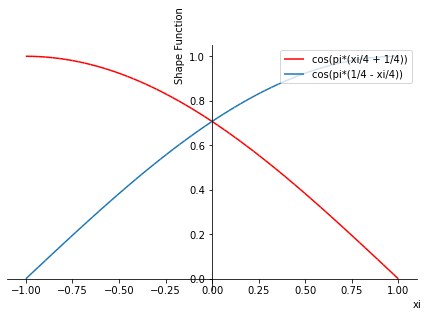

In [15]:
p = plot(N1, N2, (xi, -1, 1), ylabel='Shape Function', show=False)
p[0].line_color = 'red'
p.legend = True
p.show()

# b)

In [17]:
x = symbols('x')

In [18]:
locatio_function_N1 = N1 * x
locatio_function_N1

x*cos(pi*(xi/4 + 1/4))

In [19]:
locatio_function_N2 = N2 * x
locatio_function_N2

x*cos(pi*(1/4 - xi/4))

In [20]:
locatio_function_N1 = locatio_function_N1.subs(x, 0)
locatio_function_N1

0

In [21]:
locatio_function_N2 = locatio_function_N2.subs(x, 1)
locatio_function_N2

cos(pi*(1/4 - xi/4))

In [22]:
location_function = locatio_function_N1 + locatio_function_N2
location_function

cos(pi*(1/4 - xi/4))

In [23]:
jac = diff(location_function, xi)
jac

pi*sin(pi*(1/4 - xi/4))/4

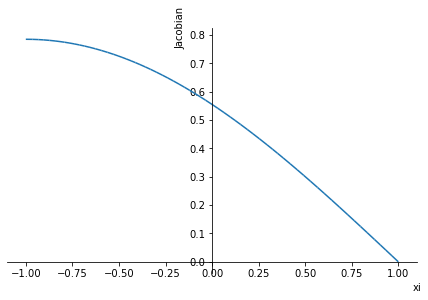

In [24]:
jac_plot = plot(jac, (xi, -1, 1), ylabel='Jacobian')

# c)

In [37]:
A = Matrix(1,1, [1])
J_inv = Matrix([jac]).inv()
J_det = Matrix([jac]).det()
N = Matrix(1, 2, [diff(N1, xi), diff(N2, xi)])

B = A * J_inv * N

B_trans = B.T

E = symbols('E')
D = E

A = symbols('A')

A * B_trans * D * B * J_det

Matrix([
[                   pi*A*E*sin(pi*(xi/4 + 1/4))**2/(4*cos(pi*xi/4 + pi/4)), -pi*A*E*sin(pi*(1/4 - xi/4))*sin(pi*(xi/4 + 1/4))/(4*cos(pi*xi/4 + pi/4))],
[-pi*A*E*sin(pi*(1/4 - xi/4))*sin(pi*(xi/4 + 1/4))/(4*cos(pi*xi/4 + pi/4)),                    pi*A*E*sin(pi*(1/4 - xi/4))**2/(4*cos(pi*xi/4 + pi/4))]])

# 11

# a)

In [66]:
# Create shape functions and put them into a list
N1 = ((xi-0)*(xi-1)*(eta-1)) / -4
N2 = ((xi+1)*(xi-1)*(eta-1)) / 2
N3 = ((xi+1)*(xi-0)*(eta-1)) / -4
N4 = ((xi+1)*(xi-0)*(eta+1)) / 4
N5 = ((xi+1)*(xi-1)*(eta+1)) / -2
N6 = ((xi-0)*(xi-1)*(eta+1)) / 4

shape_funcs_ls = np.array([N1, N2, N3, N4, N5, N6])

# Print shape function matrix
Matrix(shape_funcs_ls)

Matrix([
[      -xi*(eta - 1)*(xi - 1)/4],
[ (eta - 1)*(xi - 1)*(xi + 1)/2],
[      -xi*(eta - 1)*(xi + 1)/4],
[       xi*(eta + 1)*(xi + 1)/4],
[-(eta + 1)*(xi - 1)*(xi + 1)/2],
[       xi*(eta + 1)*(xi - 1)/4]])

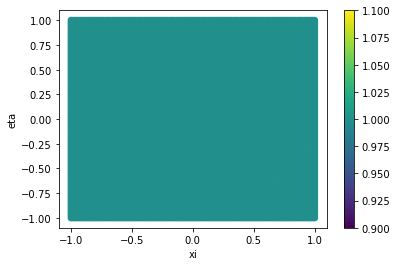

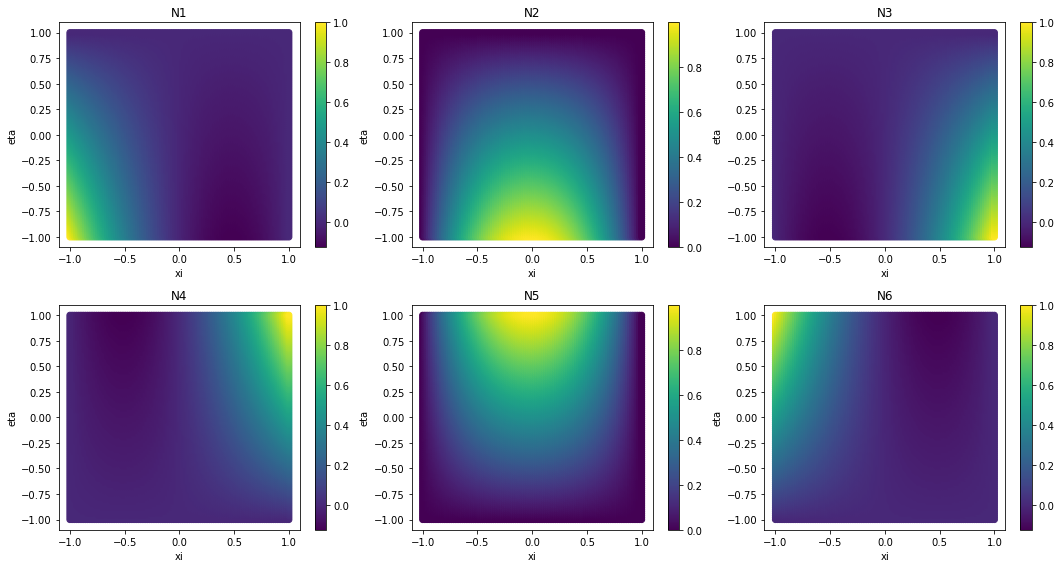

In [69]:
#------------------ Use lambdify function to be able to evaluate them numerically ------------------#
xi = symbols('xi')
eta = symbols('eta')
lambdified_shape_funcs_mat = lambdify([xi, eta], shape_funcs_ls, 'numpy')

#------------------ Create xi_2d array --------------------#
npoints = 100
value   = np.linspace(-1,1,npoints).reshape(1, npoints)
xi_2d   = np.zeros([value.shape[1]**2, 2])
counter = 0
for i in range(value.shape[1]):
    for j in range(value.shape[1]):
        xi_2d[counter,0] = value[0,i]
        xi_2d[counter,1] = value[0,j]
        counter = counter + 1
        
#------------------ Evaluate all shape functions at given locations and sum them --------------------#
evaluated_shape_funcs_mat = lambdified_shape_funcs_mat(xi_2d[:,0], xi_2d[:,1])
shape_funcs_sum = sum(evaluated_shape_funcs_mat)

#------------------ Plot sum of shape functions --------------------#
plt.scatter(xi_2d[:,0], xi_2d[:, 1], c=shape_funcs_sum)
plt.xlabel('xi')
plt.ylabel('eta')
plt.colorbar()
plt.show()

#------------------ Plot shape functions --------------------#
plot_titles = ['N1', 'N2', 'N3', 'N4', 'N5', 'N6']
plt.figure(figsize=(15,8))
for i, shape_func in enumerate(evaluated_shape_funcs_mat, start=1):
    plt.subplot(2,3,i)
    plt.scatter(xi_2d[:,0], xi_2d[:,1], c=shape_func)
    plt.xlabel('xi')
    plt.ylabel('eta')
    plt.title(plot_titles[i-1])
    plt.tight_layout()
    plt.colorbar()
plt.show()